### Control Lab equipment remotely
* Sun EC13 temperature chamber
* CAEN N6724 digitizer
* CAEN N14171HV supply

In [ ]:
# setup
import sys
CRANEPATH = '/opt/cranelab/CraneLab-build/'
if sys.path[-1] != CRANEPATH:
    sys.path.append(CRANEPATH)

import numpy as np

import clhvcontrol
import risingsun 
import pyCaenN6725

### Operate the high voltage

In [106]:
# currently the hv is connected via USB
# (will change to e0ternet at some point)
HVPORT='/dev/ttyACM0'
HVPORT='/dev/serial/by-id/usb-CAEN_SPA_NIM_Desktop_HV_Power_Supply-if00'
LOGLEVEL=30
try:
    hv = clhvcontrol.CAENN1471HV(port=HVPORT,
                                 loglevel=LOGLEVEL,
                                 time_delay=1.0)
except Exception as e:
    print(e)
    print ('Something went wrong, try executing the cell again!')






  0%|          | 0/10 [00:00<?, ?it/s]



 20%|██        | 2/10 [00:00<00:00, 19.95it/s]



 40%|████      | 4/10 [00:00<00:00, 19.72it/s]



 60%|██████    | 6/10 [00:00<00:00, 19.51it/s]



 80%|████████  | 8/10 [00:00<00:00, 19.39it/s]



100%|██████████| 10/10 [00:00<00:00, 19.25it/s]

In [112]:
# do something - activate the power

hv.channel0.voltage_as_set = 250
hv.channel0.current_as_set = 100.0 # 10 micro amps
hv.channel0.ramp_up = 3
hv.channel0.ramp_down = 3
hv.channel0.activate()






  0%|          | 0/83 [00:00<?, ?it/s]



  1%|          | 1/83 [00:01<01:22,  1.00s/it]



  2%|▏         | 2/83 [00:02<01:21,  1.00s/it]



  4%|▎         | 3/83 [00:03<01:20,  1.00s/it]



  5%|▍         | 4/83 [00:04<01:19,  1.00s/it]



  6%|▌         | 5/83 [00:05<01:18,  1.00s/it]



  7%|▋         | 6/83 [00:06<01:17,  1.01s/it]



  8%|▊         | 7/83 [00:07<01:16,  1.01s/it]



 10%|▉         | 8/83 [00:08<01:15,  1.01s/it]



 11%|█         | 9/83 [00:09<01:14,  1.01s/it]



 12%|█▏        | 10/83 [00:10<01:13,  1.00s/it]



 13%|█▎        | 11/83 [00:11<01:12,  1.01s/it]



 14%|█▍        | 12/83 [00:12<01:11,  1.01s/it]



 16%|█▌        | 13/83 [00:13<01:10,  1.01s/it]



 17%|█▋        | 14/83 [00:14<01:09,  1.01s/it]



 18%|█▊        | 15/83 [00:15<01:08,  1.01s/it]



 19%|█▉        | 16/83 [00:16<01:07,  1.01s/it]



 20%|██        | 17/83 [00:17<01:06,  1.01s/it]



 22%|██▏       | 18/83 [00:18<01:05,  1.01s/it]



 23%|██▎       | 19/83 [00:19<01:04,  1.01s/i

In [113]:
# and deactivate
hv.channel0.ramp_down = 3
hv.channel0.deactivate()





  0%|          | 0/83 [00:00<?, ?it/s]



  1%|          | 1/83 [00:01<01:22,  1.00s/it]



  2%|▏         | 2/83 [00:02<01:21,  1.00s/it]



  4%|▎         | 3/83 [00:03<01:20,  1.00s/it]



  5%|▍         | 4/83 [00:04<01:19,  1.00s/it]



  6%|▌         | 5/83 [00:05<01:18,  1.00s/it]



  7%|▋         | 6/83 [00:06<01:17,  1.01s/it]



  8%|▊         | 7/83 [00:07<01:16,  1.01s/it]



 10%|▉         | 8/83 [00:08<01:15,  1.01s/it]



 11%|█         | 9/83 [00:09<01:14,  1.01s/it]



 12%|█▏        | 10/83 [00:10<01:13,  1.01s/it]



 13%|█▎        | 11/83 [00:11<01:12,  1.01s/it]



 14%|█▍        | 12/83 [00:12<01:11,  1.01s/it]



 16%|█▌        | 13/83 [00:13<01:10,  1.01s/it]



 17%|█▋        | 14/83 [00:14<01:09,  1.01s/it]



 18%|█▊        | 15/83 [00:15<01:08,  1.01s/it]



 19%|█▉        | 16/83 [00:16<01:07,  1.01s/it]



 20%|██        | 17/83 [00:17<01:06,  1.01s/it]



 22%|██▏       | 18/83 [00:18<01:05,  1.01s/it]



 23%|██▎       | 19/83 [00:19<01:04,  1.01s/i

### Operate the SUN EC13 temperature chamber

In [115]:
import time
import numpy as np

import risingsun


SUNPORT = '/dev/ttyUSB2'
SUNPORT='/dev/serial/by-id/usb-Prologix_Prologix_GPIB-USB_Controller_PX30FLUZ-if00-port0'
sunec = risingsun.chamber.SunChamber(risingsun.chamber.PrologixUsbGPIBController(port=SUNPORT),
                                     publish=False,
                                     port=SUNPORT)

SUN EC13 chamber reporting status....
Power ON
Last command ok
Time out LED OFF
Not waiting for timeout
Heat output is disabled
Cool output is enabled
Valid set temperature
Deviation limit ok
Not currently ramping
Chamber temp > lower limit
Chamber temp < upper limit
Not waiting at a BKPNT
Not in LP run mode
Not in LP remote store mode
Not in local edit LP mode
Not waiting to run LP as TOD
No GPIB bus timeout
Not in local keyboard lockout mode
System self test was ok
----------------------------------


In [92]:
# power it on

sunec.ON

Turning on chamber...


<IPython.core.display.Javascript object>


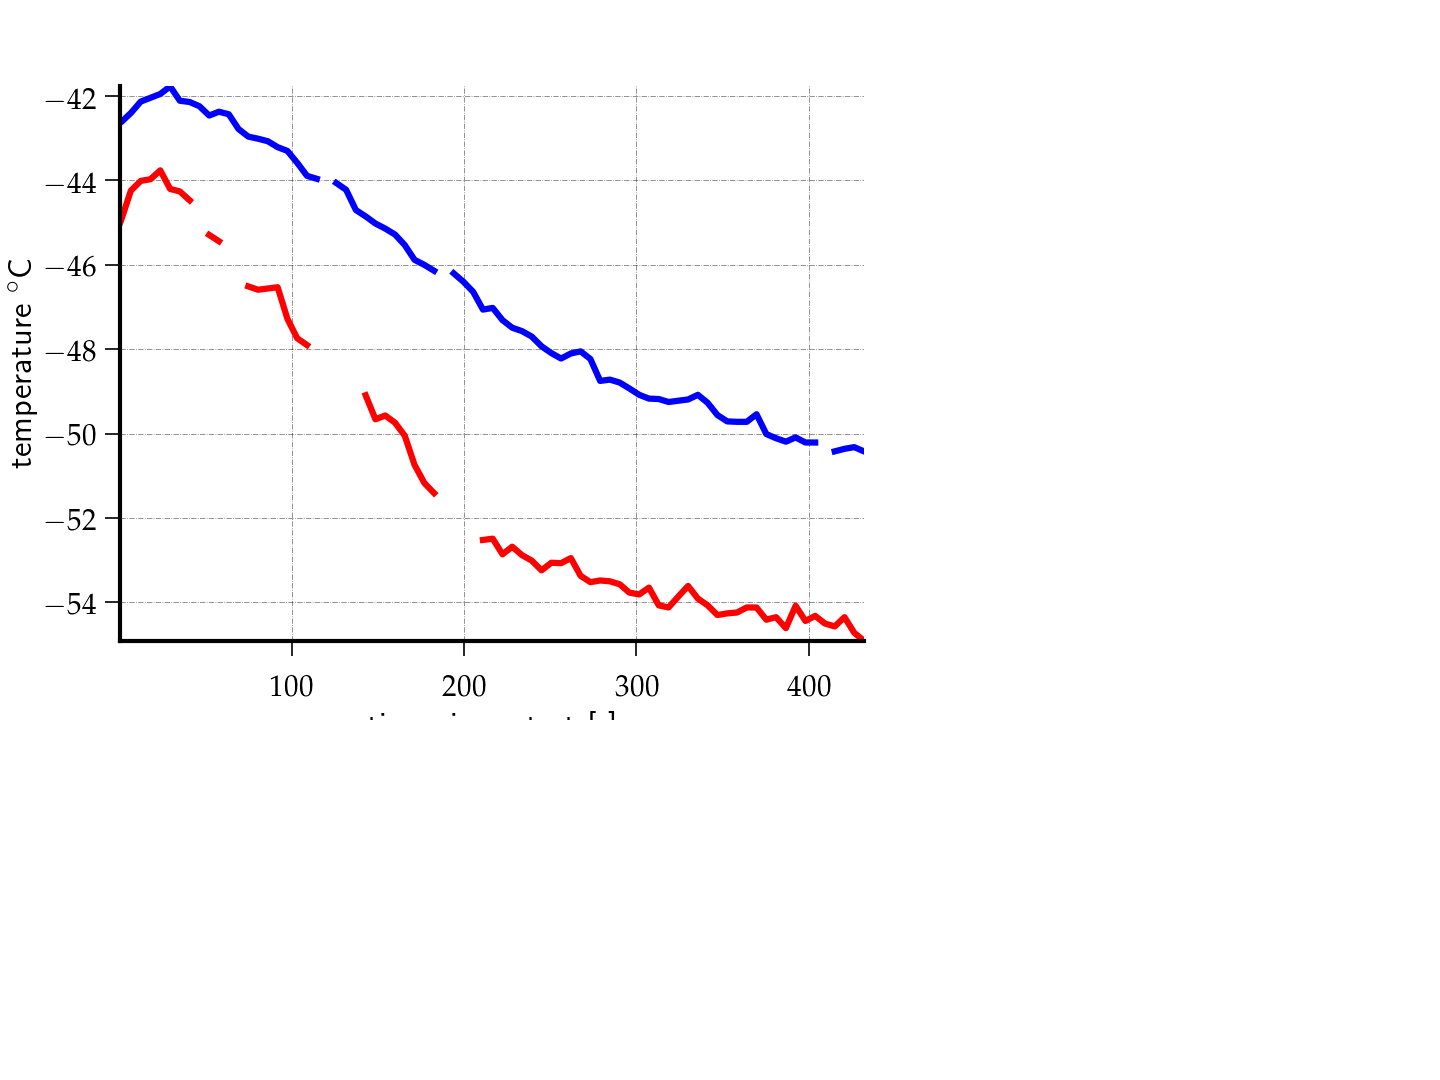

In [ ]:
# cooldown
sunec.activate_cooler()
sunec.deactivate_heater()
sunec.rate_as_set = 3
sunec.temperature_as_set = -55
monitor_internal_temperatures()

<IPython.core.display.Javascript object>


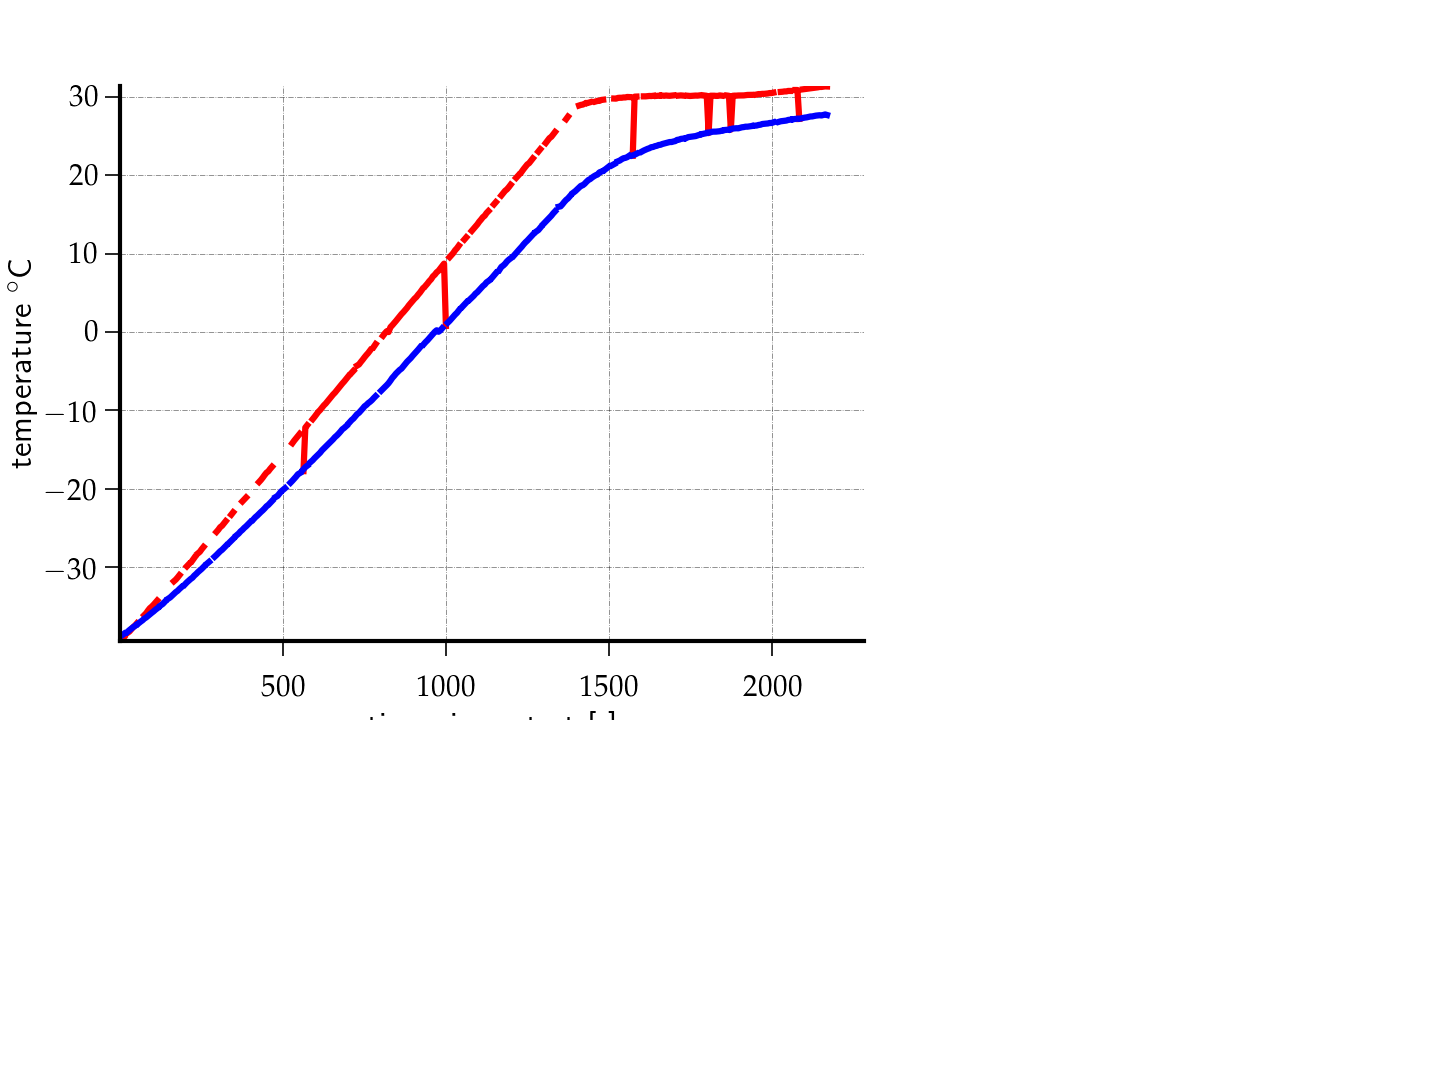

KeyboardInterrupt: 

In [89]:
sunec.deactivate_cooler()
sunec.activate_heater()
sunec.temperature_as_set = 30
sunec.open_dry_nitrogen_valve()
monitor_internal_temperatures()

In [87]:
# warmup
#FIMXE: close the valve
sunec.rate_as_set = 3
sunec.open_dry_nitrogen_valve()
#time.sleep(10)

sunec.deactivate_cooler()
sunec.activate_heater()
sunec.temperature_as_set = 30

In [ ]:
# turn it off

sunec.OFF

In [ ]:
sunec.open_dry_nitrogen_valve()

In [ ]:
sunec.close_dry_nitrogen_valve()

In [ ]:
monitor_internal_temperatures()

In [ ]:
%matplotlib notebook
# readout


import pylab as p
try:
    p.style.use('risingsun')
    p.style.use('HErmes-present')
except Exception as e:
    print(e)
    print('Style files not found, no worries...')
    
def monitor_internal_temperatures():
    fig = p.figure(dpi=150)
    ax = fig.gca()
    ax.set_xlabel("time since start [s]")
    ax.set_ylabel("temperature $^{\circ}$C")
    p.ion()
    line_plots = [ax.plot(range(0), color=k, lw=3)[0] for k in ("r", "b")]


    start_time = time.monotonic()

    fig.show()
    fig.canvas.draw()

    while True:
        sec = time.monotonic() - start_time
        datamins, datamaxes = [],[]
        for ch, line_plot in enumerate(line_plots):
        
            temp = sunec.get_temperature(ch)
            secs, temps = line_plot.get_data()
            secs = np.append(secs,sec)
            temps = np.append(temps,temp)
            line_plot.set_ydata(temps)
            line_plot.set_xdata(secs)
            datamins.append(min(temps))
            datamaxes.append(max(temps))
            xmin = min(secs)
            xmax = max(secs)
            
        datamax = max(datamaxes)
        datamin = min(datamins)
        #print(secs)
        if len(secs) == 1:
            continue
    
        # avoid matplotlib warning
        if abs(datamin - datamax) < 1:
            datamin -= 1
            datamax += 1

        if abs(xmax - xmin) < 1:
            xmin -= 1
            xmax += 1

        # update the plot
        ax.set_xlim(xmin=xmin, xmax=xmax)
        ax.set_ylim(ymin=datamin, ymax=datamax)

    
        fig.canvas.draw()
        time.sleep(5)